In [1]:
library(R.matlab)
library(ggplot2)
library(fda)
library(caTools)
library(repr)
library(MASS)

R.matlab v3.6.1 (2016-10-19) successfully loaded. See ?R.matlab for help.

Attaching package: ‘R.matlab’

The following objects are masked from ‘package:base’:

    getOption, isOpen

Loading required package: splines
Loading required package: Matrix

Attaching package: ‘fda’

The following object is masked from ‘package:graphics’:

    matplot



In [194]:
# Change plot size to 5 x 4
options(repr.plot.width=5, repr.plot.height=4)

In [3]:
# Read data
post_lag10 <- source('data/post_epoch_models10.Rdmpd')
post_lag150 <- source('data/post_epoch_models150.Rdmpd')
post_lag299 <- source('data/post_epoch_models299.Rdmpd')

# Get models for lags: 10, 150, 299
model10 = post_lag10[[1]]
model150 = post_lag150[[1]]
model299 = post_lag299[[1]]

In [4]:
# Utility function to get the factors from models
get_factors <- function(model, num_epochs=300) {
    factors_list = list()
    for (epoch in 1:num_epochs) {
        factor = model[, epoch]$f
        factor = (factor - mean(factor)) / sd(factor)
        factors_list[[epoch]] = factor
    }
    res <- do.call(cbind, factors_list)
    return(res)
}

# Utilitiy function to get MSE from models
get_mse <- function(model, num_epochs=300) {
    mse_list = list()
    for (epoch in 1:num_epochs) {
        mse = model[, epoch]$mse
        mse_list[[epoch]] = mse
    }
    return(mse_list)
}

In [5]:
# Get post factors for GDPCA
G10 = get_factors(model10)
G150 = get_factors(model150)
G299 = get_factors(model299)

# Get MSE for GDPCA
mse10 = get_mse(model10)
mse150 = get_mse(model150)
mse299 = get_mse(model299)

# Read post factors for SPCA
S = as.matrix(read.csv("data/factor1_post_normalized_removed.csv"))[, 2:1001]

# Take transpose of SPCA for functional boxplots
S = t(S)

In [6]:
# Collect log periodograms of factors for each epoch
log_periodograms <- function(factors, num_epochs, smooth=TRUE, window=11, tlim=500) {
    
    # Smooth the log periodograms
    smoothing <- function(log_pds, w=window) {
        sm_log_pd_list = list()
        for(i in 1:num_epochs) {
            sm_log_pd = stats::filter(log_pds[[i]], rep(1/w, w), circular=TRUE)
            sm_log_pd_list[[i]] = sm_log_pd
        }
        res <- do.call(cbind, sm_log_pd_list)
        return (res)
    }
    
    logpd.list = c()
    for (i in 1:num_epochs) {
        factor_epoch = factors[, i]
        periodogram = (abs(fft(factor_epoch)))^2
        log_pd = log(periodogram[1:tlim])
        logpd.list[[i]] = log_pd
    }
    if (smooth) {
        res <- smoothing(logpd.list)
    }
    else {
        res <- do.call(cbind, logpd.list)
    }
    return (res)
}

In [7]:
# Get log periodograms for SPCA and GDPC
P_s = log_periodograms(S, num_epochs=300)
P_g10 = log_periodograms(G10, num_epochs=300, smooth=FALSE)
P_g150 = log_periodograms(G150, num_epochs=300, smooth=FALSE)
P_g299 = log_periodograms(G299, num_epochs=300, smooth=FALSE)

In [184]:
plot_factors <- function(GDPC, SPCA, epoch) {
    ulim = max(max(SPCA[5:995, epoch], GDPC[5:995, epoch]))
    llim = min(min(SPCA[5:995, epoch], GDPC[5:995, epoch]))
    par(mar=c(6.1, .5, 2.1, 6.1), xpd=TRUE)
    plot(GDPC[5:995, epoch], xaxt="n", yaxt="n", type='l', ylab='',ylim=c(llim, ulim),
         main=sprintf("Epoch %s: First Factors", epoch),xlab='ms', bty="n", col="darkblue")
    lines(SPCA[5:995, epoch], col=2, xpd=FALSE)
    axis(side=1, at=seq(0, 1000, 1000))
    par(xpd=TRUE)
    legend("topright", ex.cs1, cex=0.9, y.intersp=2.5,legend=c("GDPCA", "SPCA"), bty="n", 
           lty=c(1,1),col=c("darkblue", "red"), inset=c(-0.3, 0), text.font=2)
}

plot_periodograms <-function(Xgpd, Xspd, epoch) {
    ulim = max(max(Xspd[7:495, epoch], Xgpd[7:495, epoch]))
    llim = min(min(Xspd[7:495, epoch], Xgpd[7:495, epoch]))
    par(mar=c(6.1, 0.5, 4.1, 4.1), xpd=TRUE)
    plot(Xspd[7:495, epoch], xaxt="n", yaxt="n", type='l', ylab='', xlab='Hz',ylim=c(llim, ulim),
         main=sprintf("Epoch %s: Log Periodograms", epoch), bty='n', col='red')
    lines(Xgpd[7:495, epoch], col="darkblue", xpd=FALSE)
    axis(side=1, at=seq(0, 500, 500))
    legend("topright", ex.cs1, cex=0.9, y.intersp=2.5,legend=c("GDPCA", "SPCA"), bty="n", 
           lty=c(1,1),col=c("darkblue", "red"), inset=c(-.17, 0), text.font=2)
}

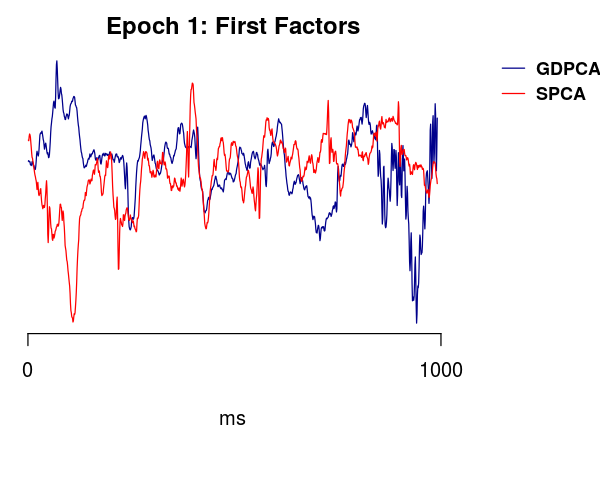

In [195]:
plot_factors(G150, S, 1)

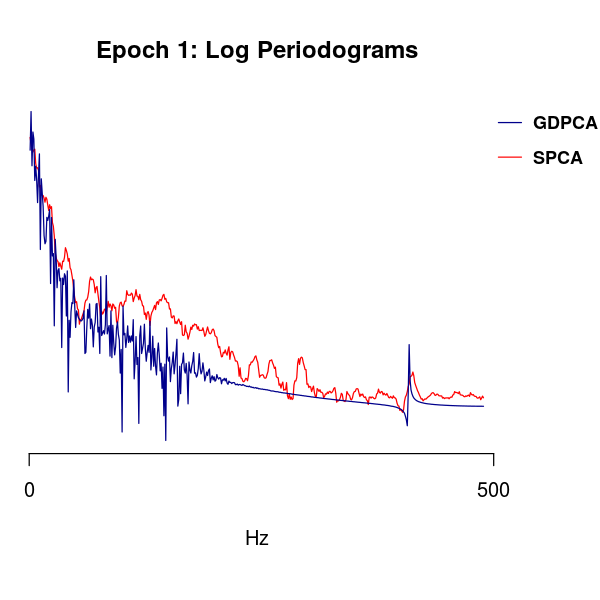

In [189]:
plot_periodograms(P_g10, P_s, 1)

In [192]:
# Functions to save factors and log periodograms
save_factor_plots <- function(G, S, epochs, subdir="lagx_factors") {
    pardir =  "."
    if (!dir.exists(file.path(pardir, subdir))) {
        dir.create(file.path(pardir, subdir))
    }

    for (i in epochs) {
        png(filename=sprintf("%s/%s_epoch%s.png", subdir, subdir, i),
            width=5, height=5, units="in", res=600)
        plot_factors(G, S, i)
        dev.off()
    }
}

save_logp_plots <- function(G, S, epochs, subdir="lagx_logp") {
    pardir =  "."
    if (!dir.exists(file.path(pardir, subdir))) {
        dir.create(file.path(pardir, subdir))
    }

    for (i in epochs) {
        png(filename=sprintf("%s/%s_epoch%s.png", subdir, subdir, i),
            width=5, height=5, units="in", res=600)
        plot_periodograms(G, S, i)
        dev.off()
    }
}

In [193]:
# save factors and log periodograms for post (all epochs)
epochs = c(1:300)
save_factor_plots(G10, S, epochs, subdir="lag10_factors")
save_logp_plots(P_g10, P_s, epochs, subdir="lag10_logp")

save_factor_plots(G150, S, epochs, subdir="lag150_factors")
save_logp_plots(P_g150, P_s, epochs, subdir="lag150_logp")

save_factor_plots(G299, S, epochs, subdir="lag299_factors")
save_logp_plots(P_g299, P_s, epochs, subdir="lag299_logp")